### Importing the data

In [1]:
# Import all the Dependencies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('fivethirtyeight')

# Feature Engineering 
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

# Model Selection
from sklearn.model_selection import train_test_split

# handle Imbalanced Data
from imblearn.over_sampling import RandomOverSampler

#Models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier


# Model Evaluation
from sklearn.metrics import classification_report, confusion_matrix

# Hyper-Tuning 
from sklearn.model_selection import RandomizedSearchCV

import warnings
warnings.filterwarnings('ignore')

In [58]:
# reading the data
df=pd.read_csv('Churn.csv')
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


### Understanding the data

In [3]:
print('Data Size:',df.shape)

Data Size: (7043, 21)


In [4]:
#Checking Null values if any
df.isnull().sum()

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

## Checking Imbalance Data

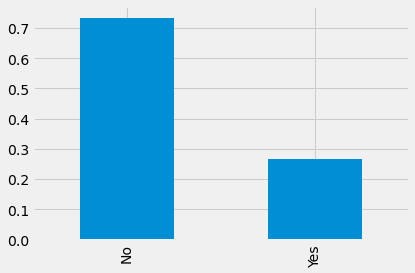

In [5]:
df['Churn'].value_counts(normalize=True).plot(kind='bar')

We can see the given data is imabalanced means more amount of data belongs to No Churn class. we will take care of it in feature engineering step.

### Data Visualization ( Exploratory Data Analysis )

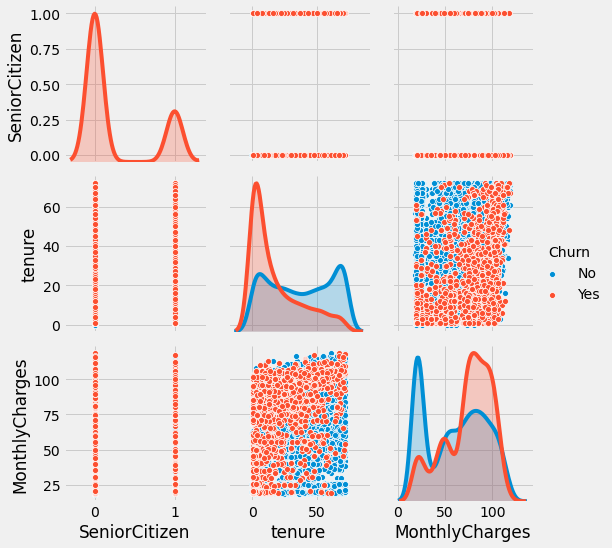

In [6]:
sns.pairplot(df,hue='Churn')

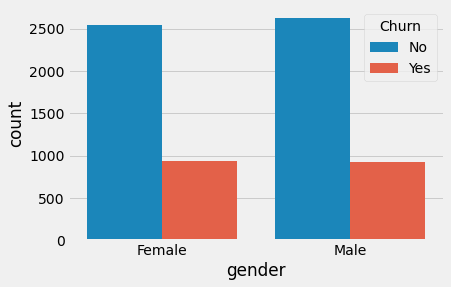

In [7]:
sns.countplot(df['gender'],hue=df['Churn'])

no significant relation between the Churn and Gender.

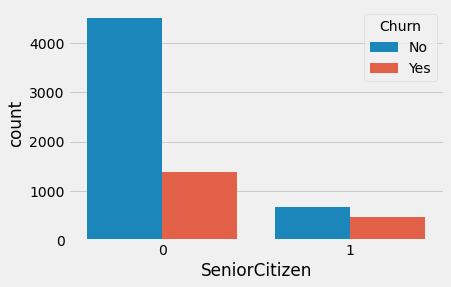

In [8]:
sns.countplot(df['SeniorCitizen'],hue=df['Churn'])

on the basis of data, one who is not Senior citizen more likely to be churned compare to Senior citizen.

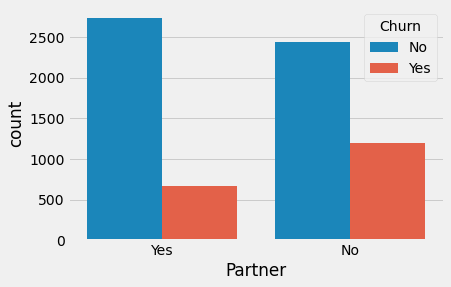

In [9]:
sns.countplot(df['Partner'],hue=df['Churn'])

One who doesn't have partners got most churned.

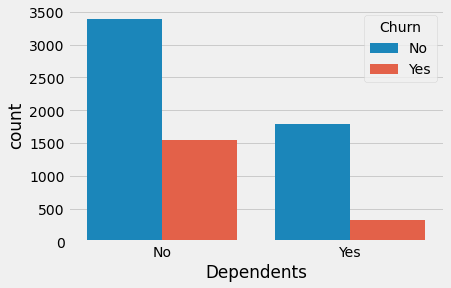

In [10]:
sns.countplot(df['Dependents'],hue=df['Churn'])

One who doesn't have dependents got most churned

<Figure size 720x1152 with 0 Axes>

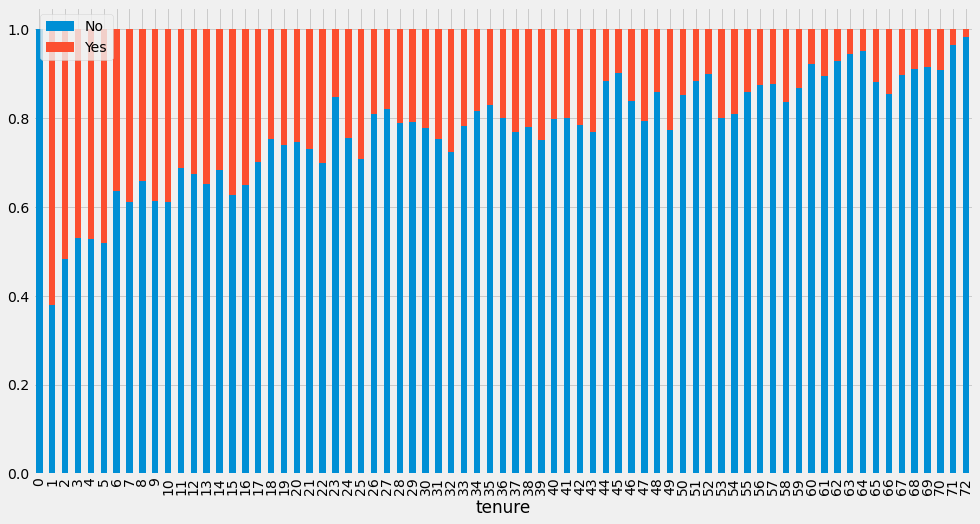

In [11]:
plt.figure(figsize=(10,16))
exp=pd.crosstab(df['tenure'],df['Churn']) 
exp.div(exp.sum(1).astype(float), axis=0).plot(kind="bar", stacked=True,figsize=(15,8))
plt.legend(loc='best')

We can see that new customers have a maximum churning rate, we can convert these months into years so it would be easy to target the new customers.

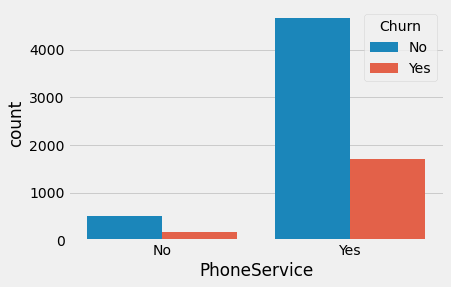

In [12]:
sns.countplot(df['PhoneService'],hue=df['Churn'])

One who has taken phone service more likely to be churn, so phone service should be improved.

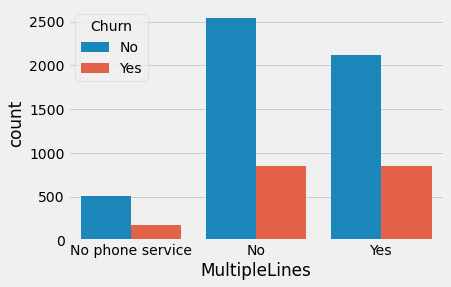

In [13]:
sns.countplot(df['MultipleLines'],hue=df['Churn'])

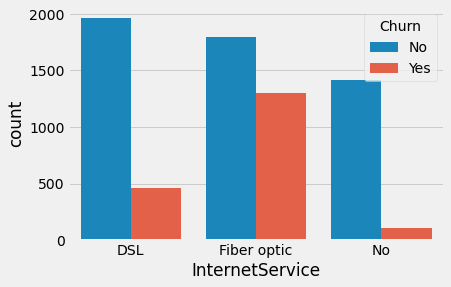

In [14]:
sns.countplot(df['InternetService'],hue=df['Churn'])

Who has taken fiber optic internet service more likely to be churn.

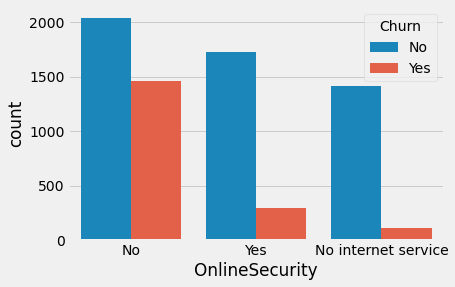

In [15]:
sns.countplot(df['OnlineSecurity'],hue=df['Churn'])

We know the consequences of Cyber vulnerability, so it's obvious customer will trust us if we will give them full security.

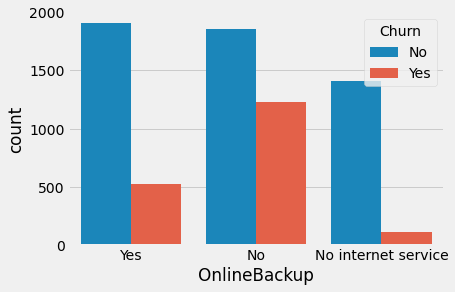

In [16]:
sns.countplot(df['OnlineBackup'],hue=df['Churn'])

the customers who not getting online backup services more likely to be churn.

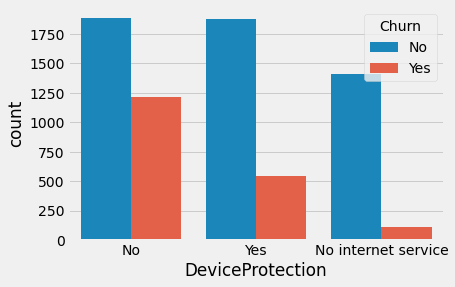

In [17]:
sns.countplot(df['DeviceProtection'],hue=df['Churn'])

One who has not got Device protection guarantee more likely to be churn.

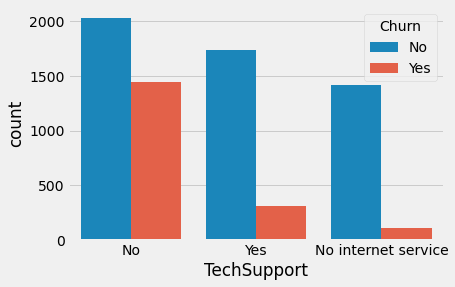

In [18]:
sns.countplot(df['TechSupport'],hue=df['Churn'])

One who has no technology support more likely to be churn.

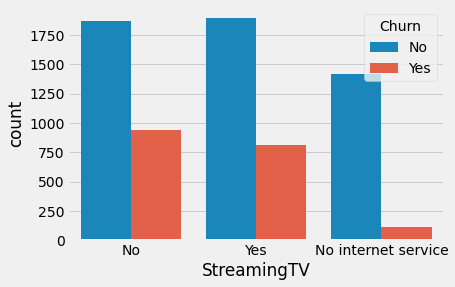

In [19]:
sns.countplot(df['StreamingTV'],hue=df['Churn'])

There is no significant change between the churning rate of with StreamingTV and without StreamingTV services. but at some point one who has not this service more likely to be churn.

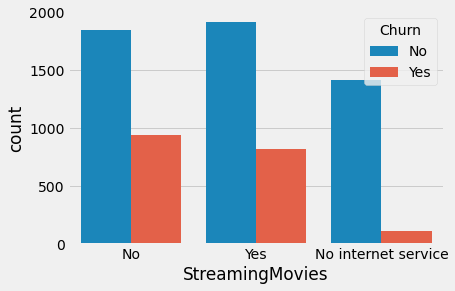

In [20]:
sns.countplot(df['StreamingMovies'],hue=df['Churn'])

We can see the same depiction as of above.

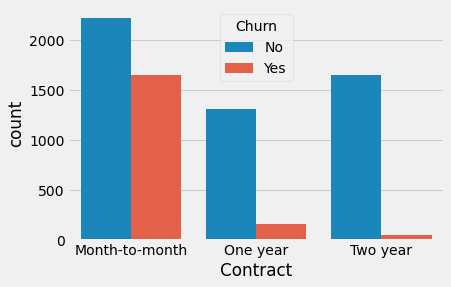

In [21]:
sns.countplot(df['Contract'],hue=df['Churn'])

We have to focus on the retaintion of Month-Month Customers by providing them good quality services.

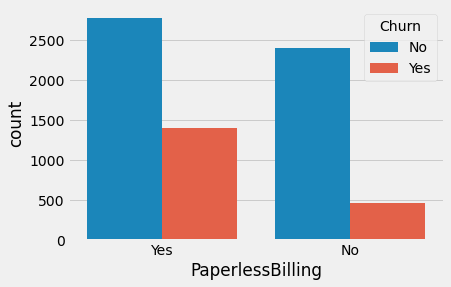

In [22]:
sns.countplot(df['PaperlessBilling'],hue=df['Churn'])

One who has gone through this feature is more likely to be churn.

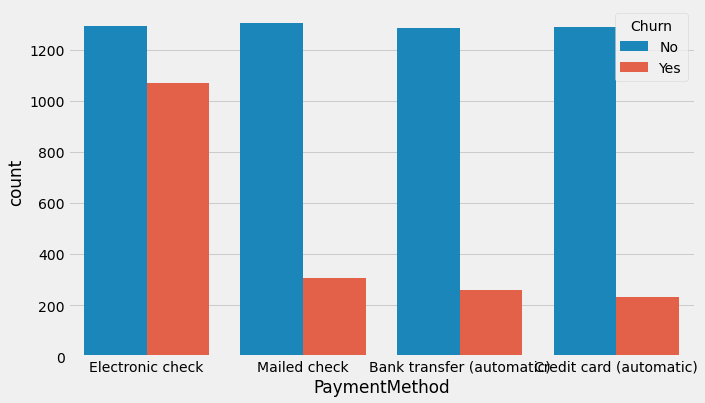

In [23]:
plt.figure(figsize=(10,6))
sns.countplot(df['PaymentMethod'],hue=df['Churn'])

We can see most of customers who has chosen Electronic payment method more likely to be churn.

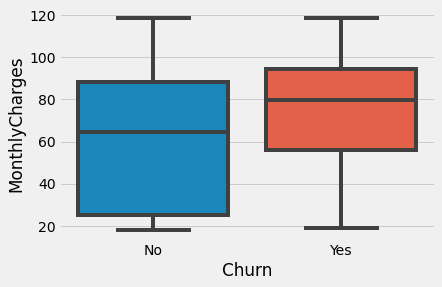

In [24]:
sns.boxplot(y=df['MonthlyCharges'],x=df['Churn'])

We can see one who paying more likely to be churn more.

In [25]:
# convert string into float and replace with 0 values if any blank

df['TotalCharges']=df['TotalCharges'].replace(' ',0)
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], downcast="float")


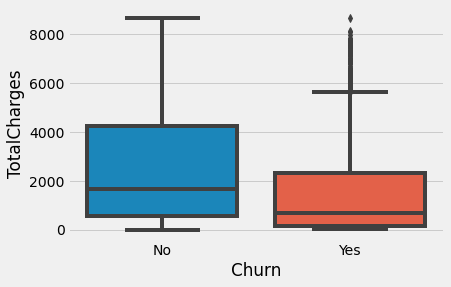

In [26]:
sns.boxplot(y=df['TotalCharges'],x=df['Churn'])


We can see the outliers present in the total charges With respect to churn rate. we will take care of it in next step.

### Data Manipulation ( Feature Engineering )

In [27]:
# Convert all the categorical features into numerical
# define class
encode=LabelEncoder()

df['gender']=encode.fit_transform(df['gender'])
df['Partner']=encode.fit_transform(df['Partner'])
df['Dependents']=encode.fit_transform(df['Dependents'])
df['PhoneService']=encode.fit_transform(df['PhoneService'])
df['MultipleLines']=encode.fit_transform(df['MultipleLines'])
df['InternetService']=encode.fit_transform(df['InternetService'])
df['OnlineSecurity']=encode.fit_transform(df['OnlineSecurity'])
df['OnlineBackup']=encode.fit_transform(df['OnlineBackup'])
df['DeviceProtection']=encode.fit_transform(df['DeviceProtection'])
df['TechSupport']=encode.fit_transform(df['TechSupport'])
df['StreamingTV']=encode.fit_transform(df['StreamingTV'])
df['StreamingMovies']=encode.fit_transform(df['StreamingMovies'])
df['Contract']=encode.fit_transform(df['Contract'])
df['PaperlessBilling']=encode.fit_transform(df['PaperlessBilling'])
df['PaymentMethod']=encode.fit_transform(df['PaymentMethod'])
df['Churn']=encode.fit_transform(df['Churn'])




In [28]:
# Convert tenure feature into 3 category (i have taken 2 year difference according to the previous Analysis.)
# 0-24Months-->1, 25-48 Months--->2 and else is 3

df['tenure']=df['tenure'].map(lambda x: 1 if x<=24 else 2 if x<=48 else 3)

In [29]:
#define class
scale=StandardScaler()

df['MonthlyCharges']=scale.fit_transform(df['MonthlyCharges'].values.reshape(-1,1))
df['TotalCharges']=scale.fit_transform(df['TotalCharges'].values.reshape(-1,1))

### Handling Outliers

In [30]:
# df.groupby('Churn')['TotalCharges'].mean()
mean=1531.796143
df1=df[(df['Churn']=='Yes') & (df['TotalCharges']>=mean)]['TotalCharges'].map(lambda x: mean if x>mean else x)
df['TotalCharges'].update(df1)

### Multicolinearity

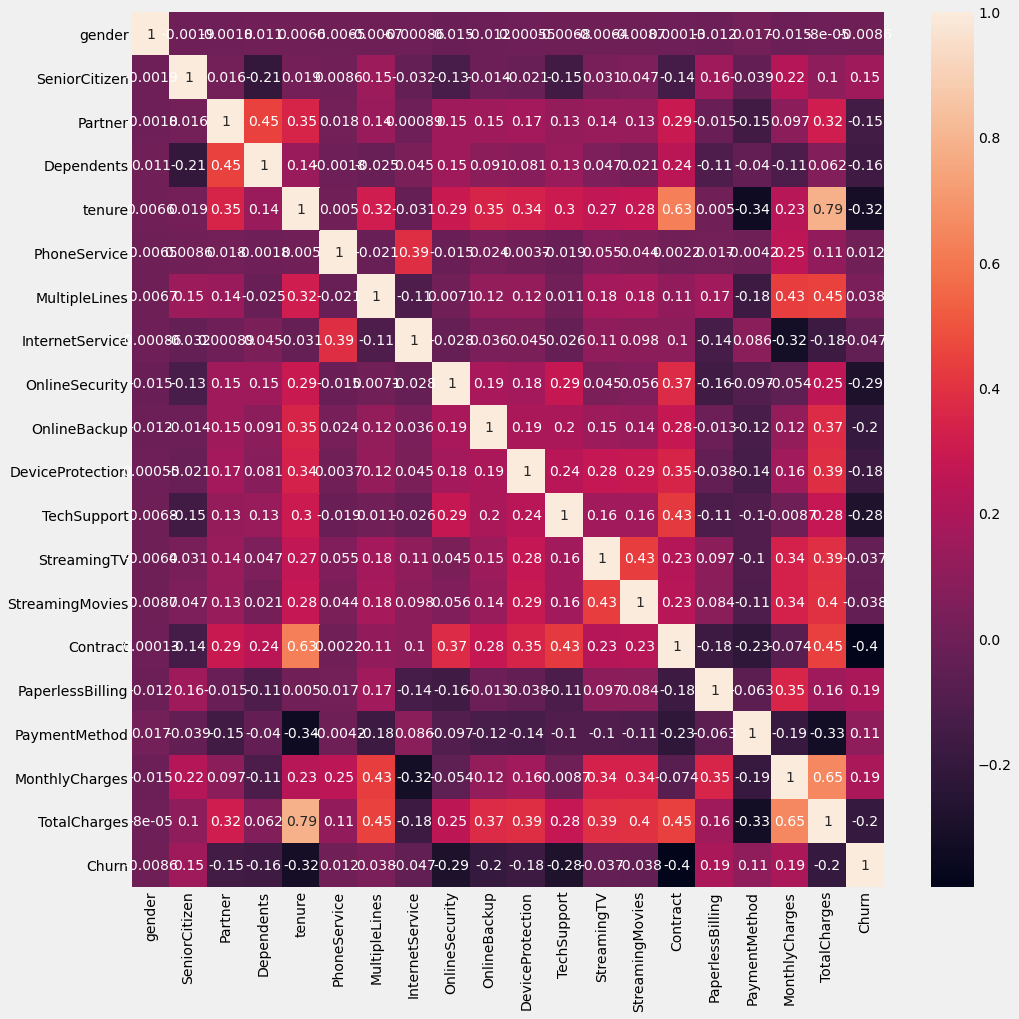

In [31]:
plt.figure(figsize=(15,15))
sns.heatmap(df.corr(),annot=True)

We can see tenure is highly correlated with Contract and TotalCharges features. I have to delete this feature to avoid multicolinearity problem.

In [32]:
# split the features
X=df.drop(['customerID','Churn','tenure'],axis=1)
y=df['Churn']

In [33]:
# We have Imbalanced Data and we have to do sampling to avoid this problem
# we have two method so for 1] Under Sampling, 2] Oversampling
# I will go for Oversampling.

sample=RandomOverSampler()
X_sample,y_sample=sample.fit_sample(X,y)

## Train Test Split

In [34]:

X_train,X_test,y_train,y_test=train_test_split(X_sample,y_sample,test_size=0.2)

### Implement Machine Learning Models and Evaluations

In [35]:
# start with basic model (Logistic Regression)

reg=LogisticRegression(max_iter=1000)
reg.fit(X_train,y_train)
y_pred=reg.predict(X_test)

report=classification_report(y_test,y_pred)
matrix=confusion_matrix(y_test,y_pred)

print('Classification Report:\n',report)
print('Confusion Matrix :\n',matrix)



Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.73      0.76      1050
           1       0.74      0.80      0.77      1020

    accuracy                           0.77      2070
   macro avg       0.77      0.77      0.77      2070
weighted avg       0.77      0.77      0.76      2070

Confusion Matrix :
 [[766 284]
 [202 818]]


In [36]:
# Now lets go for my favourite one 

random=RandomForestClassifier()
random.fit(X_train,y_train)
y_pred=random.predict(X_test)

report=classification_report(y_test,y_pred)
matrix=confusion_matrix(y_test,y_pred)

print('Classification Report:\n',report)
print('Confusion Matrix :\n',matrix)


Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.84      0.89      1050
           1       0.85      0.95      0.90      1020

    accuracy                           0.90      2070
   macro avg       0.90      0.90      0.89      2070
weighted avg       0.90      0.90      0.89      2070

Confusion Matrix :
 [[882 168]
 [ 49 971]]


### Hyper-Tuning Technique

In [37]:

params={'n_estimators':[i for i in  range(100,2000,200)],
      'max_depth':[1,2,4,5,10,15,20,30,35,40],
       'min_samples_split':[1,2,4,5,10,15,20],
       'min_samples_leaf':[1,2,6,8,10,15,20,25,30]}

clf= RandomForestClassifier()

model=RandomizedSearchCV(clf,param_distributions=params,cv=3)

model.fit(X_train,y_train)

RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
               

In [38]:
model.best_score_

0.8145694022023662

We can see hyper-tuning is not improving the accuracy, still we got the good accuracy.

We got almost 90% F1-Score without Hyper-Tuning.


In [39]:
features=pd.DataFrame({'Important_features':random.feature_importances_},index=X.columns)

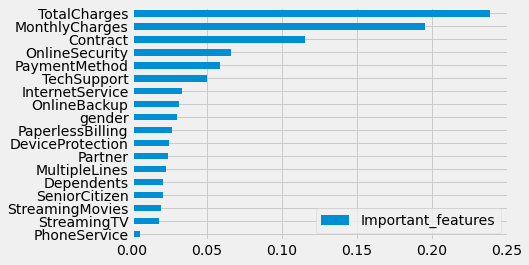

In [40]:
features.sort_values(by='Important_features',ascending=True).plot(kind='barh')

In [41]:
import pickle
filename='churn_rfc.pkl'
pickle.dump(random,open(filename,'wb'))


In [50]:
X

,gender,SeniorCitizen,Partner,Dependents,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,0,0,1,0,0,1,0,0,2,0,0,0,0,0,1,2,-1.160323,-0.992611
1,1,0,0,0,1,0,0,2,0,2,0,0,0,1,0,3,-0.259629,-0.172165
2,1,0,0,0,1,0,0,2,2,0,0,0,0,0,1,3,-0.362660,-0.958066
3,1,0,0,0,0,1,0,2,0,2,2,0,0,1,0,0,-0.746535,-0.193672
4,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,2,0.197365,-0.938874
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,1,0,1,1,1,2,0,2,0,2,2,2,2,1,1,3,0.665992,-0.127605
7039,0,0,1,1,1,2,1,0,2,2,0,2,2,1,1,1,1.277533,2.242606
7040,0,0,1,1,0,1,0,2,0,0,0,0,0,0,1,2,-1.168632,-0.852932
7041,1,1,1,0,1,2,1,0,0,0,0,0,0,0,1,3,0.320338,-0.870513


In [83]:
x=[[0,0,0,0,1,2,1,0,0,2,0,2,2,0,1,0,70.8,60.8]]


random.predict(x)

array([1])

In [63]:
df

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,6840-RESVB,Male,0,Yes,Yes,24,Yes,Yes,DSL,Yes,...,Yes,Yes,Yes,Yes,One year,Yes,Mailed check,84.80,1990.5,No
7039,2234-XADUH,Female,0,Yes,Yes,72,Yes,Yes,Fiber optic,No,...,Yes,No,Yes,Yes,One year,Yes,Credit card (automatic),103.20,7362.9,No
7040,4801-JZAZL,Female,0,Yes,Yes,11,No,No phone service,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.60,346.45,No
7041,8361-LTMKD,Male,1,Yes,No,4,Yes,Yes,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Mailed check,74.40,306.6,Yes


In [80]:
y_pred

array([0, 1, 1, ..., 1, 1, 0])

In [81]:
X_test

,gender,SeniorCitizen,Partner,Dependents,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
449,1,0,1,1,1,0,1,2,2,0,2,2,2,2,0,0,1.353976,2.352306
3838,0,0,0,0,1,2,1,0,0,2,0,2,2,0,1,0,1.187796,0.141274
8949,1,0,0,0,1,0,1,0,0,0,0,0,0,0,1,2,0.160806,-0.975074
4868,0,0,1,0,1,2,1,0,0,2,0,2,2,0,1,2,1.154560,0.653950
7390,0,0,0,0,1,0,1,0,0,0,0,0,2,0,1,2,0.491503,-0.686628
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7370,1,0,0,0,1,0,0,0,0,0,2,0,0,0,0,3,-0.440765,-0.608495
6249,1,0,0,0,1,2,1,0,0,0,0,0,0,0,0,2,0.323662,-0.909845
8938,0,0,1,0,1,2,1,0,0,0,0,0,0,0,1,1,0.310367,-0.905190
113,0,1,1,0,1,2,1,0,0,0,0,0,0,0,1,2,0.390134,0.259599
